In [1]:
import time
import numpy as np
from psygine.datasets.utils import readcfl
from psygine.decoders.utils import ifft2c

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

def show_grid_image(X):
    cols = int(np.ceil(np.sqrt(X.shape[0])))
    rows = int(np.ceil(X.shape[0] / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(len(X)):
        magnitude = np.abs(X[i])
        phase = np.angle(X[i])
        mag_norm = magnitude / (np.max(magnitude) + 1e-6)  # Avoid division by zero
        hsv = np.zeros((*mag_norm.shape, 3), dtype=np.float32)
        hsv[..., 0] = (phase + np.pi) / (2 * np.pi)
        hsv[..., 1] = 1.0
        hsv[..., 2] = mag_norm
        rgb = hsv_to_rgb(hsv)

        axes[i].imshow(rgb, aspect='auto')
        axes[i].axis('off')

    for j in range(len(X), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
!wget https://raw.githubusercontent.com/mikgroup/espirit-python/master/data/knee.cfl
!wget https://raw.githubusercontent.com/mikgroup/espirit-python/master/data/knee.hdr

--2025-08-07 21:57:27--  https://raw.githubusercontent.com/mikgroup/espirit-python/master/data/knee.cfl
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.39
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5242880 (5.0M) [application/octet-stream]
Saving to: ‘knee.cfl’

knee.cfl            100%[===================>]   5.00M   714KB/s    in 8.6s    

2025-08-07 21:57:38 (594 KB/s) - ‘knee.cfl’ saved [5242880/5242880]

--2025-08-07 21:57:38--  https://raw.githubusercontent.com/mikgroup/espirit-python/master/data/knee.hdr
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.39
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [4]:
X = readcfl("knee")
X = np.transpose(X, (3, 0, 1, 2))
X = np.ascontiguousarray(np.squeeze(X))
[N_CH, N_PE, N_SPE] = X.shape

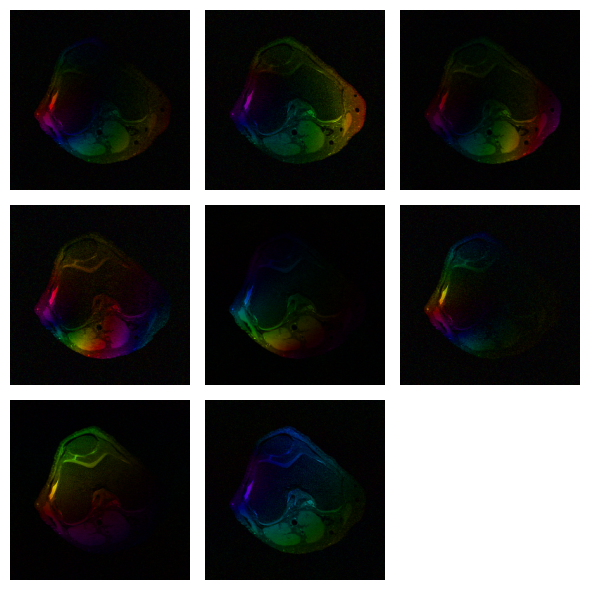

In [5]:
show_grid_image(ifft2c(X))

In [6]:
from psygine.decoders.mri import espirit, espirit_Gq, espirit_mikgroup

In [7]:
%load_ext memory_profiler

In [8]:
%%memit

start_time = time.perf_counter()
maps = espirit(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH, 
    crop_threshold=0,
    normalize=False)
end_time = time.perf_counter()
maps = np.squeeze(maps[0])
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 3.190977 seconds
peak memory: 492.68 MiB, increment: 212.97 MiB


In [9]:
%%memit

start_time = time.perf_counter()
maps_Gq = espirit_Gq(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH, 
    crop_threshold=0,
    normalize=False)
maps_Gq = np.squeeze(maps_Gq[0])
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 5.849367 seconds
peak memory: 1637.73 MiB, increment: 1193.16 MiB


In [10]:
%%memit

start_time = time.perf_counter()
maps_mik = espirit_mikgroup(
    np.transpose(X.reshape(-1, 1, *X.shape[-2:]), (1, 2, 3, 0)),
    k=6,
    r=24,
    t=1e-2,
    c=0)
maps_mik = maps_mik[..., :1]
maps_mik = np.transpose(maps_mik, (4, 3, 0, 1, 2))
maps_mik = np.squeeze(maps_mik)
ref = np.copy(maps_mik[0])
ref /= np.abs(ref)
maps_mik *= np.conj(ref)
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:.6f} seconds")


Time elapsed: 81.865081 seconds
peak memory: 1342.52 MiB, increment: 833.09 MiB


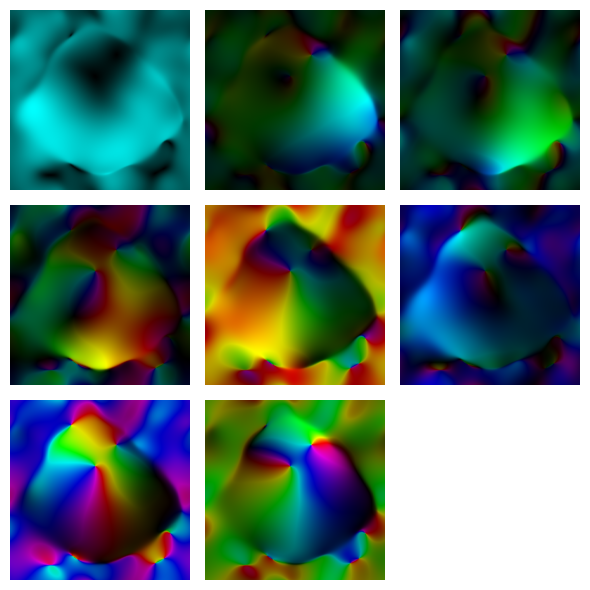

In [11]:
show_grid_image(maps)

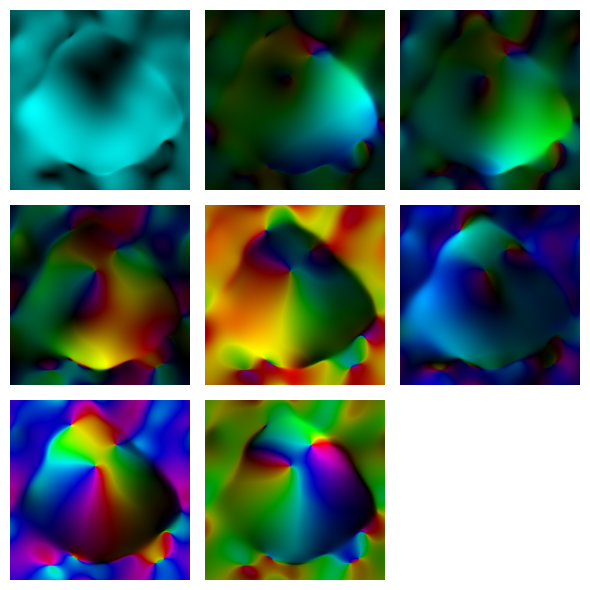

In [12]:
show_grid_image(maps_Gq)

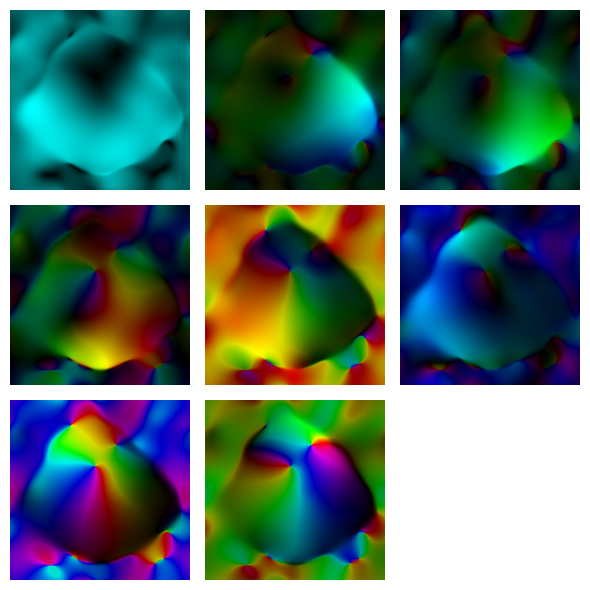

In [13]:
show_grid_image(maps_mik)